In [22]:
!pip install gudhi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gudhi as gd
import gudhi.weighted_rips_complex


In [23]:
distance_matrix = pd.read_csv("dmv_Symmetric_Distance_Matrix.csv", index_col=0).values
wait_vector = np.genfromtxt("dmv_waits.csv", delimiter=",")


In [24]:
print(len(distance_matrix))

167


In [25]:
# Create the weighted Vietoris–Rips complex
cpx = gd.weighted_rips_complex.WeightedRipsComplex(
    distance_matrix=distance_matrix,
    weights=wait_vector
).create_simplex_tree(max_dimension=2)  # computes up to 1D homology


In [26]:
# Compute persistent homology
cpx.compute_persistence()

# Extract birth/death pairs
ph = cpx.persistence()

# Convert birth/death times from seconds to minutes (more interpretable)
ph_minutes = [(dim, (b/60, d/60)) for dim, (b, d) in ph if d < float("inf")]


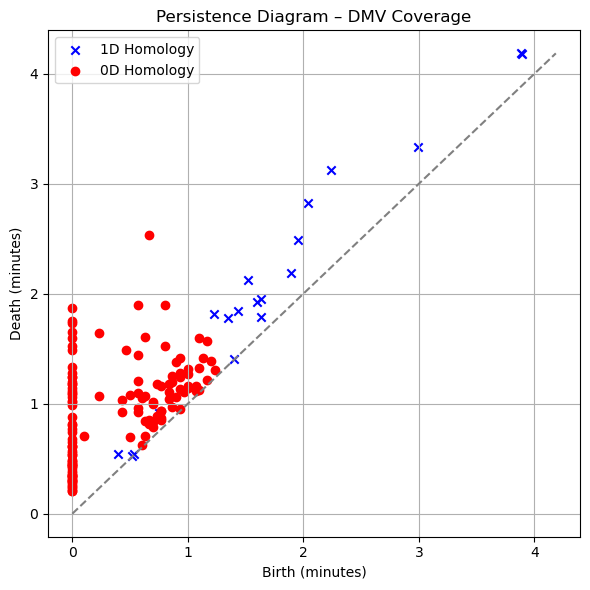

In [27]:
# Plot the persistence diagram
plt.figure(figsize=(6, 6))

for dim, (b, d) in ph_minutes:
    if dim == 0:
        plt.scatter(b, d, color='red', label='0D Homology' if '0D Homology' not in plt.gca().get_legend_handles_labels()[1] else "")
    elif dim == 1:
        plt.scatter(b, d, color='blue', marker='x', label='1D Homology' if '1D Homology' not in plt.gca().get_legend_handles_labels()[1] else "")

# Diagonal reference line
max_val = max(d for _, (_, d) in ph_minutes)
plt.plot([0, max_val], [0, max_val], linestyle='--', color='gray')

# Labels and layout
plt.xlabel("Birth (minutes)")
plt.ylabel("Death (minutes)")
plt.title("Persistence Diagram – DMV Coverage")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [31]:
dmv_df = pd.read_csv('pre-processing/output/dmv_offices_details.csv')

# Use the weighted rips complex from earlier (cell 3) which has compute_persistence method
weighted_cpx = gd.weighted_rips_complex.WeightedRipsComplex(
    distance_matrix=distance_matrix,
    weights=wait_vector
).create_simplex_tree(max_dimension=2)

weighted_cpx.compute_persistence()
ph = weighted_cpx.persistence()
all_pairs = weighted_cpx.persistence_pairs()
offices = dmv_df['office_name'].tolist()

# Analyze death simplices to identify specific offices
print("\n=== DEATH SIMPLICES ANALYSIS ===")
pairs_1d = [pair for pair in all_pairs if len(pair[1]) == 3]  # 1D features have 3 vertices

if pairs_1d:
    feature_data = [[pair[1], weighted_cpx.filtration(pair[1])] for pair in pairs_1d]
    feature_data.sort(key=lambda x: x[1], reverse=True)
    
    print("1D features (triangular arrangements):")
    for i, (simplex, death_val) in enumerate(feature_data):
        office_names = [offices[vertex] for vertex in simplex]
        # Get lat/long coordinates for each office in the simplex
        office_coords = []
        for vertex in simplex:
            lat = dmv_df.iloc[vertex]['latitude']
            lon = dmv_df.iloc[vertex]['longitude']
            office_coords.append(f"({lat:.4f}, {lon:.4f})")
        
        print(f"{i+1}. Death filtration: {death_val:.1f}")
        print(f"   Offices: {office_names}")
        print(f"   Coordinates: {office_coords}")
        print("   ---")

print("\n✅ Analysis complete!")


=== DEATH SIMPLICES ANALYSIS ===
1D features (triangular arrangements):
1. Death filtration: 251.1
   Offices: ['Truckee', 'South Lake Tahoe', 'Bishop']
   Coordinates: ['(39.3280, -120.1833)', '(38.9423, -119.9772)', '(37.3613, -118.4126)']
   ---
2. Death filtration: 251.0
   Offices: ['Mariposa', 'Bishop', 'Arvin']
   Coordinates: ['(37.4962, -119.9676)', '(37.3613, -118.4126)', '(35.2113, -118.8333)']
   ---
3. Death filtration: 199.8
   Offices: ['Yreka', 'Weaverville', 'Crescent City']
   Coordinates: ['(41.7017, -122.6461)', '(40.7189, -122.9274)', '(41.7723, -124.1851)']
   ---
4. Death filtration: 187.5
   Offices: ['Weaverville', 'Redding', 'Eureka']
   Coordinates: ['(40.7189, -122.9274)', '(40.5753, -122.3806)', '(40.7796, -124.1902)']
   ---
5. Death filtration: 169.7
   Offices: ['Rancho San Diego Industry Business Center', 'Palm Springs', 'Brawley']
   Coordinates: ['(32.7578, -116.9242)', '(33.8360, -116.5191)', '(32.9687, -115.5349)']
   ---
6. Death filtration: 149.5

In [34]:
# ==============================================================================
# ZIP CODE UNDERSERVED ANALYSIS
# ==============================================================================

import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Polygon
import os

print("🎯 ZIP CODE UNDERSERVED ANALYSIS")
print("=" * 50)

# Use the existing persistent homology results
print("🔬 Using existing persistent homology results...")
print(f"✅ Found {len(pairs_1d)} death simplices (1D features)")

# Create triangle polygons from death simplices coordinates
print("🔺 Creating triangle polygons from death simplices...")
triangles = []

for i, (simplex, death_val) in enumerate(feature_data):
    try:
        # Get coordinates for the three offices in this simplex
        coords = []
        office_names = []
        
        for vertex in simplex:
            lat = dmv_df.iloc[vertex]['latitude']
            lon = dmv_df.iloc[vertex]['longitude']
            name = dmv_df.iloc[vertex]['office_name']
            coords.append((lon, lat))  # Note: (lon, lat) for Shapely
            office_names.append(name)
        
        # Create triangle polygon
        if len(coords) == 3:
            triangle = Polygon(coords)
            triangles.append({
                'geometry': triangle,
                'simplex_id': i,
                'office_names': office_names,
                'vertices': list(simplex)
            })
            
    except Exception as e:
        print(f"   ⚠️ Error creating triangle for simplex {i}: {e}")
        continue

print(f"✅ Created {len(triangles)} triangle polygons")

# Load California ZIP codes
print("🗺️ Loading California ZIP codes...")
zip_codes_file = "pre-processing/data/zip_data/zip_poly.shp"

if os.path.exists(zip_codes_file):
    # Load shapefile
    zip_gdf = gpd.read_file(zip_codes_file)
    
    # Convert to WGS84 if needed
    if zip_gdf.crs != 'EPSG:4326':
        print("🔄 Converting to WGS84...")
        zip_gdf = zip_gdf.to_crs('EPSG:4326')
    
    # Filter for California ZIP codes and ensure string type
    zip_gdf['ZIP_CODE'] = zip_gdf['ZIP_CODE'].astype(str)
    ca_mask = (
        (zip_gdf['ZIP_CODE'].str.startswith('90')) |
        (zip_gdf['ZIP_CODE'].str.startswith('91')) |
        (zip_gdf['ZIP_CODE'].str.startswith('92')) |
        (zip_gdf['ZIP_CODE'].str.startswith('93')) |
        (zip_gdf['ZIP_CODE'].str.startswith('94')) |
        (zip_gdf['ZIP_CODE'].str.startswith('95')) |
        (zip_gdf['ZIP_CODE'].str.startswith('96')) |
        (zip_gdf['ZIP_CODE'].str.startswith('00'))
    )
    
    zip_gdf = zip_gdf[ca_mask].copy()
    print(f"✅ Loaded {len(zip_gdf)} California ZIP codes")
    
    # Analyze ZIP codes for intersection with death simplex triangles
    print("🔍 Analyzing ZIP codes for underservice...")
    
    results = []
    underserved_count = 0
    
    for idx, zip_row in zip_gdf.iterrows():
        try:
            zip_code = zip_row['ZIP_CODE']
            zip_name = zip_row.get('PO_NAME', f'ZIP {zip_code}')
            zip_geom = zip_row.geometry
            
            # Check intersection with any death simplex triangle
            is_underserved = False
            intersecting_triangles = []
            
            for triangle_info in triangles:
                triangle_geom = triangle_info['geometry']
                
                # Check if ZIP polygon intersects with triangle
                if zip_geom.intersects(triangle_geom):
                    is_underserved = True
                    intersecting_triangles.append({
                        'simplex_id': triangle_info['simplex_id'],
                        'office_names': triangle_info['office_names']
                    })
            
            # Determine status
            status = "UNDERSERVED" if is_underserved else "NOT UNDERSERVED"
            if is_underserved:
                underserved_count += 1
            
            # Store result
            result = {
                'ZIP_CODE': zip_code,
                'ZIP_NAME': zip_name,
                'STATUS': status,
                'INTERSECTING_TRIANGLES_COUNT': len(intersecting_triangles),
                'INTERSECTING_SIMPLICES': str(intersecting_triangles) if intersecting_triangles else "None"
            }
            
            results.append(result)
            
            if (idx + 1) % 100 == 0:
                print(f"   Processed {idx + 1}/{len(zip_gdf)} ZIP codes...")
                
        except Exception as e:
            print(f"   ⚠️ Error processing ZIP {zip_row.get('ZIP_CODE', 'Unknown')}: {e}")
            continue
    
    print(f"✅ Analysis complete!")
    print(f"📊 Results: {underserved_count} UNDERSERVED, {len(results) - underserved_count} NOT UNDERSERVED")
    print(f"📈 Underserved percentage: {underserved_count/len(results)*100:.1f}%")
    
    # Save results to CSV
    output_file = "pre-processing/output/zip_underserved_mapping.csv"
    print(f"💾 Saving results to {output_file}...")
    
    # Create DataFrame and save
    results_df = pd.DataFrame(results)
    os.makedirs(os.path.dirname(output_file), exist_ok=True)
    results_df.to_csv(output_file, index=False)
    
    print(f"✅ Saved {len(results)} ZIP code mappings to {output_file}")
    
    # Show summary statistics
    print("\n📊 SUMMARY STATISTICS:")
    status_counts = results_df['STATUS'].value_counts()
    for status, count in status_counts.items():
        percentage = count / len(results_df) * 100
        print(f"   {status}: {count} ({percentage:.1f}%)")
    
    # Show sample of underserved ZIP codes
    underserved = results_df[results_df['STATUS'] == 'UNDERSERVED']
    if len(underserved) > 0:
        print(f"\n🔺 Sample UNDERSERVED ZIP codes:")
        for i in range(min(5, len(underserved))):
            row = underserved.iloc[i]
            print(f"   {row['ZIP_CODE']} - {row['ZIP_NAME']} ({row['INTERSECTING_TRIANGLES_COUNT']} triangles)")

else:
    print(f"❌ ZIP codes file not found: {zip_codes_file}")
    results_df = None


🎯 ZIP CODE UNDERSERVED ANALYSIS
🔬 Using existing persistent homology results...
✅ Found 19 death simplices (1D features)
🔺 Creating triangle polygons from death simplices...
✅ Created 19 triangle polygons
🗺️ Loading California ZIP codes...
🔄 Converting to WGS84...
✅ Loaded 1778 California ZIP codes
🔍 Analyzing ZIP codes for underservice...
   Processed 100/1778 ZIP codes...
   Processed 200/1778 ZIP codes...
   Processed 300/1778 ZIP codes...
   Processed 400/1778 ZIP codes...
   Processed 500/1778 ZIP codes...
   Processed 600/1778 ZIP codes...
   Processed 700/1778 ZIP codes...
   Processed 800/1778 ZIP codes...
   Processed 900/1778 ZIP codes...
   Processed 1000/1778 ZIP codes...
   Processed 1100/1778 ZIP codes...
   Processed 1200/1778 ZIP codes...
   Processed 1300/1778 ZIP codes...
   Processed 1400/1778 ZIP codes...
   Processed 1500/1778 ZIP codes...
   Processed 1600/1778 ZIP codes...
   Processed 1700/1778 ZIP codes...
✅ Analysis complete!
📊 Results: 486 UNDERSERVED, 1292 N

🎯 ZIP CODE UNDERSERVED MAP GENERATOR
🗺️ Creating ZIP Code Underserved Map...
🔗 Merging with underserved classifications...
✅ Merged data: 1778 ZIP codes
🎨 Creating map visualization...
   Plotted 486 UNDERSERVED ZIP codes in #FF4444
   Plotted 1292 NOT UNDERSERVED ZIP codes in #44AA44
📍 Adding DMV office markers...
   Added 167 DMV office markers
✅ Map saved to: pre-processing/output/zip_underserved_map.png
📊 Summary: 486 underserved ZIP codes (27.3%)


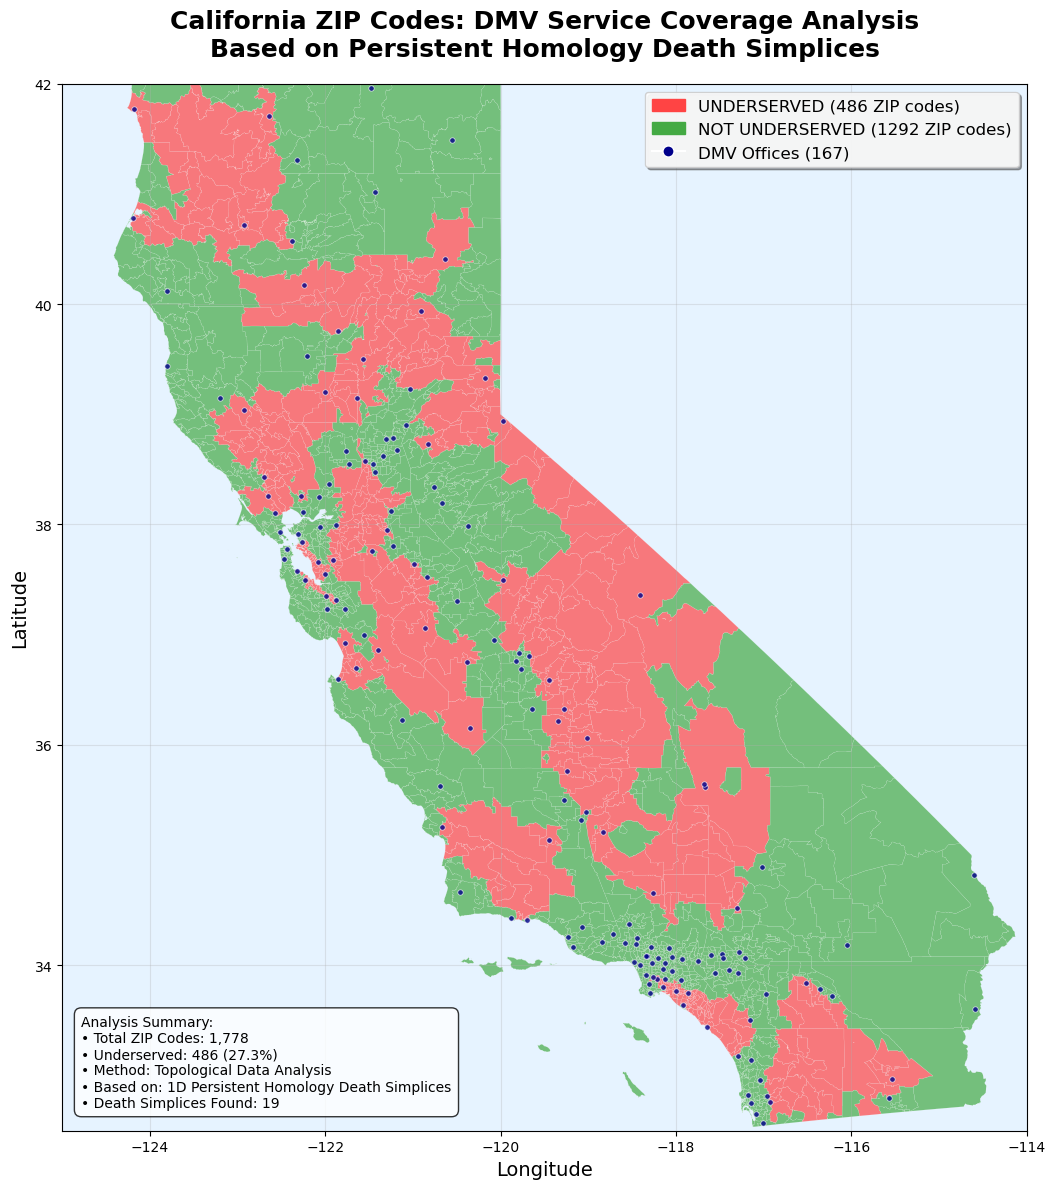


🎉 Map generation completed successfully!


In [39]:
# ==============================================================================
# ZIP CODE UNDERSERVED MAP GENERATION
# ==============================================================================

import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Only create the map if we have results from the previous analysis
if 'results_df' in locals() and results_df is not None:
    print("🎯 ZIP CODE UNDERSERVED MAP GENERATOR")
    print("=" * 50)
    
    print("🗺️ Creating ZIP Code Underserved Map...")
    
    # Merge ZIP code geometries with analysis results
    print("🔗 Merging with underserved classifications...")
    results_df['ZIP_CODE'] = results_df['ZIP_CODE'].astype(str)  # Ensure string type
    
    merged_gdf = zip_gdf.merge(results_df[['ZIP_CODE', 'STATUS']], 
                               left_on='ZIP_CODE', right_on='ZIP_CODE', how='left')
    
    # Fill any missing statuses (shouldn't happen but just in case)
    merged_gdf['STATUS'] = merged_gdf['STATUS'].fillna('NOT UNDERSERVED')
    
    print(f"✅ Merged data: {len(merged_gdf)} ZIP codes")
    
    # Create the map
    print("🎨 Creating map visualization...")
    
    # Set up the plot
    fig, ax = plt.subplots(1, 1, figsize=(16, 12))
    
    # Color mapping
    colors = {
        'UNDERSERVED': '#FF4444',      # Red
        'NOT UNDERSERVED': '#44AA44'   # Green
    }
    
    # Plot ZIP codes by status
    for status, color in colors.items():
        subset = merged_gdf[merged_gdf['STATUS'] == status]
        if len(subset) > 0:
            subset.plot(ax=ax, color=color, alpha=0.7, edgecolor='white', linewidth=0.1)
            print(f"   Plotted {len(subset)} {status} ZIP codes in {color}")
    
    # Add DMV office markers
    print("📍 Adding DMV office markers...")
    ax.scatter(dmv_df['longitude'], dmv_df['latitude'], 
              c='darkblue', s=15, marker='o', alpha=0.8, 
              edgecolors='white', linewidth=0.5, zorder=5)
    print(f"   Added {len(dmv_df)} DMV office markers")
    
    # Set map bounds to California
    ax.set_xlim(-125, -114)
    ax.set_ylim(32.5, 42)
    
    # Styling
    ax.set_title('California ZIP Codes: DMV Service Coverage Analysis\nBased on Persistent Homology Death Simplices', 
                fontsize=18, fontweight='bold', pad=20)
    ax.set_xlabel('Longitude', fontsize=14)
    ax.set_ylabel('Latitude', fontsize=14)
    
    # Remove tick labels for cleaner look
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_facecolor('#E6F3FF')  # Light blue background (ocean)
    
    # Create legend
    legend_elements = [
        patches.Patch(color='#FF4444', label=f'UNDERSERVED ({(results_df["STATUS"] == "UNDERSERVED").sum()} ZIP codes)'),
        patches.Patch(color='#44AA44', label=f'NOT UNDERSERVED ({(results_df["STATUS"] == "NOT UNDERSERVED").sum()} ZIP codes)'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='darkblue', 
                   markersize=8, label=f'DMV Offices ({len(dmv_df)})')
    ]
    
    ax.legend(handles=legend_elements, loc='upper right', fontsize=12, 
              fancybox=True, shadow=True, framealpha=0.9)
    
    # Add summary text
    underserved_count = (results_df['STATUS'] == 'UNDERSERVED').sum()
    total_count = len(results_df)
    underserved_pct = underserved_count / total_count * 100
    
    summary_text = f"""Analysis Summary:
• Total ZIP Codes: {total_count:,}
• Underserved: {underserved_count:,} ({underserved_pct:.1f}%)
• Method: Topological Data Analysis
• Based on: 1D Persistent Homology Death Simplices
• Death Simplices Found: {len(triangles)}"""
    
    ax.text(0.02, 0.02, summary_text, transform=ax.transAxes, fontsize=10,
            bbox=dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.8),
            verticalalignment='bottom')
    
    # Save the map
    output_file = "pre-processing/output/zip_underserved_map.png"
    plt.tight_layout()
    plt.savefig(output_file, dpi=300, bbox_inches='tight', 
                facecolor='white', edgecolor='none')
    
    print(f"✅ Map saved to: {output_file}")
    print(f"📊 Summary: {underserved_count} underserved ZIP codes ({underserved_pct:.1f}%)")
    
    plt.show()
    
    print("\n🎉 Map generation completed successfully!")
    
else:
    print("❌ No analysis results available. Please run the ZIP code analysis first.")
